In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

## Load dataset

In [7]:
# Downloading dataset, see here for more info https://www.tensorflow.org/tutorials/images/segmentation
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True, download=False)


In [8]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
INPUT_SIZE=(128, 128)
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE


### Normalize and resize data

In [5]:
# Normalize input and update mask value 
""" according to the tensorflow website: he pixels in the segmentation mask are labeled either {1, 2, 3}. For the sake of convenience, subtract 1 from the segmentation mask, resulting in labels that are : {0, 1, 2}."""

def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask


In [7]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], INPUT_SIZE)
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    INPUT_SIZE,
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

### Prepare datasets with data augmentation

In [9]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels


In [8]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)


In [10]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)


In [84]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()


2024-02-26 16:21:36.980587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [4]
	 [[{{node Placeholder/_3}}]]
2024-02-26 16:21:36.981162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [4]
	 [[{{node Placeholder/_3}}]]


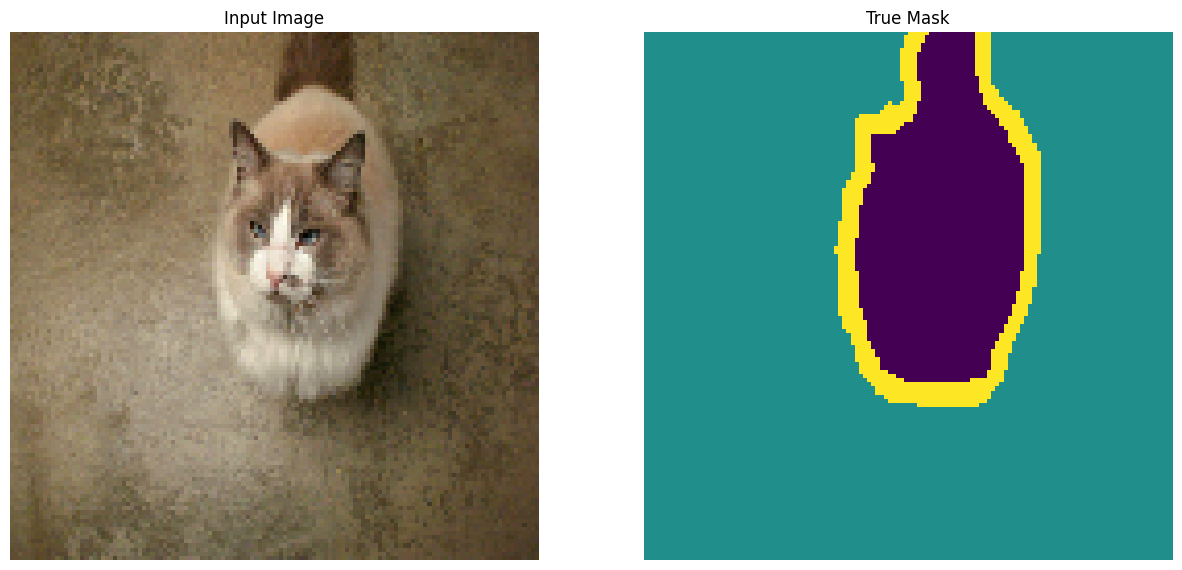

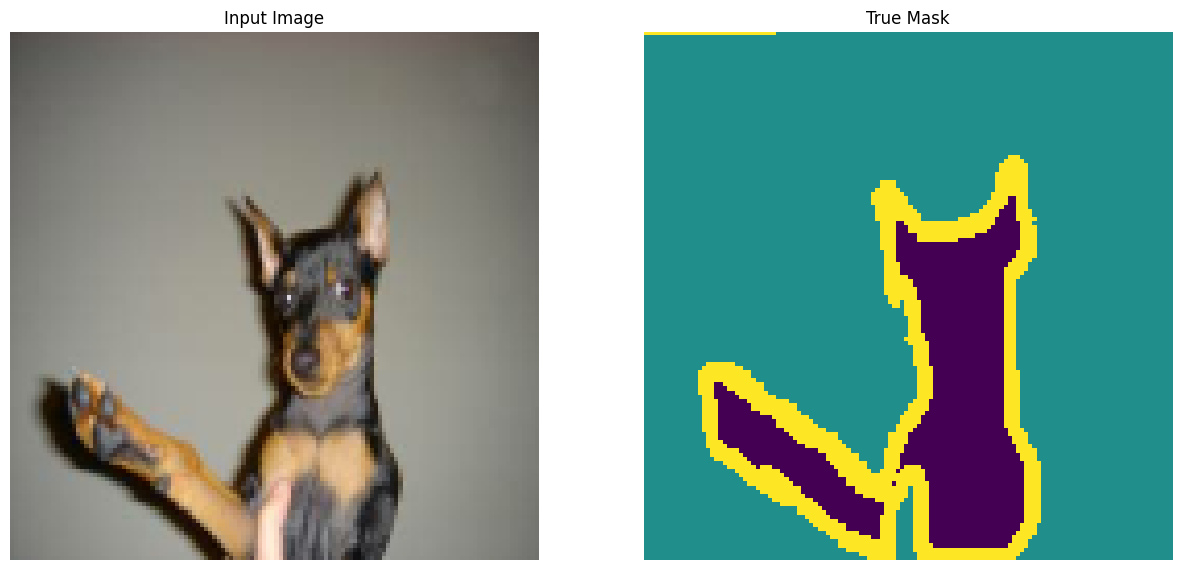

In [85]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])


## Implement U-net model

In [9]:
# Model creation
from tensorflow.keras.layers import UpSampling2D, Conv2D, MaxPooling2D
input_size = (128,128,3)
inputs = tf.keras.layers.Input(shape=INPUT_SIZE + (3,))
## DownSampling
# First conv
conv_1_1_down = Conv2D(filters=64, kernel_size=3, padding="same",activation="relu")(inputs)
conv_1_2_down = Conv2D(filters=64, kernel_size=3, padding="same",activation="relu")(conv_1_1_down)
max_pool_1 = MaxPooling2D(pool_size=(2, 2),strides=2,padding='same')(conv_1_2_down) 

# second conv
conv_2_1_down = Conv2D(filters=128, kernel_size=3, padding="same",activation="relu")(max_pool_1)
conv_2_2_down = Conv2D(filters=128, kernel_size=3, padding="same",activation="relu")(conv_2_1_down)
max_pool_2 = MaxPooling2D(pool_size=(2, 2),strides=2)(conv_2_2_down) 

# thrid conv
conv_3_1_down = Conv2D(filters=256, kernel_size=3, padding="same",activation="relu")(max_pool_2)
conv_3_2_down = Conv2D(filters=256, kernel_size=3, padding="same",activation="relu")(conv_3_1_down)
max_pool_3 = MaxPooling2D(pool_size=(2, 2),strides=2)(conv_3_2_down) 

# fourth conv
conv_4_1_down = tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding="same",activation="relu")(max_pool_3)
conv_4_2_down = tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding="same",activation="relu")(conv_4_1_down)
max_pool_4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2)(conv_4_2_down) 

# fifth conv
conv_5_1_down = tf.keras.layers.Conv2D(filters=1024, kernel_size=3, padding="same",activation="relu")(max_pool_4)
conv_5_2_down = tf.keras.layers.Conv2D(filters=1024, kernel_size=3, padding="same",activation="relu")(conv_5_1_down)
#max_pool_5 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2,padding='same')(conv_5_2_down) 

##################
## UpSampling

#first up conv
up_sample_1_1 = UpSampling2D(size=(2, 2))(conv_5_2_down)
conv_1_1_up = tf.keras.layers.Conv2D(filters=512, kernel_size=2, padding="same",activation="relu")(up_sample_1_1)
concat_1_1_up = tf.keras.layers.Concatenate(axis=3)([conv_4_2_down, conv_1_1_up])
conv_1_2_up = tf.keras.layers.Conv2D(filters=512, kernel_size=2, padding="same",activation="relu")(concat_1_1_up)


#second up conv
up_sample_2_1 = UpSampling2D(size=(2, 2))(conv_1_2_up)
conv_2_1_up = tf.keras.layers.Conv2D(filters=256, kernel_size=2, padding="same",activation="relu")(up_sample_2_1)
concat_2_up = tf.keras.layers.Concatenate(axis=3)([conv_3_2_down, conv_2_1_up])
conv_2_2_up = tf.keras.layers.Conv2D(filters=256, kernel_size=2, padding="same",activation="relu")(concat_2_up)

#third up conv
up_sample_3_1 = UpSampling2D(size=(2, 2))(conv_2_2_up)
conv_3_1_up = tf.keras.layers.Conv2D(filters=128, kernel_size=2, padding="same",activation="relu")(up_sample_3_1)
concat_3_up = tf.keras.layers.Concatenate(axis=3)([conv_2_2_down, conv_3_1_up])
conv_3_2_up = tf.keras.layers.Conv2D(filters=128, kernel_size=2, padding="same",activation="relu")(concat_3_up)

#fourth up conv
up_sample_4_1 = UpSampling2D(size=(2, 2))(conv_3_2_up)
conv_4_1_up = tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding="same",activation="relu")(up_sample_4_1)
concat_4_up = tf.keras.layers.Concatenate(axis=3)([conv_1_2_down, conv_4_1_up])
conv_4_2_up = tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding="same",activation="relu")(concat_4_up)

conv_4_3_up = tf.keras.layers.Conv2D(filters=3, kernel_size=1, padding="same",activation="softmax")(conv_4_2_up)

model = tf.keras.Model(inputs=inputs, outputs=conv_4_3_up)

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=["accuracy"])


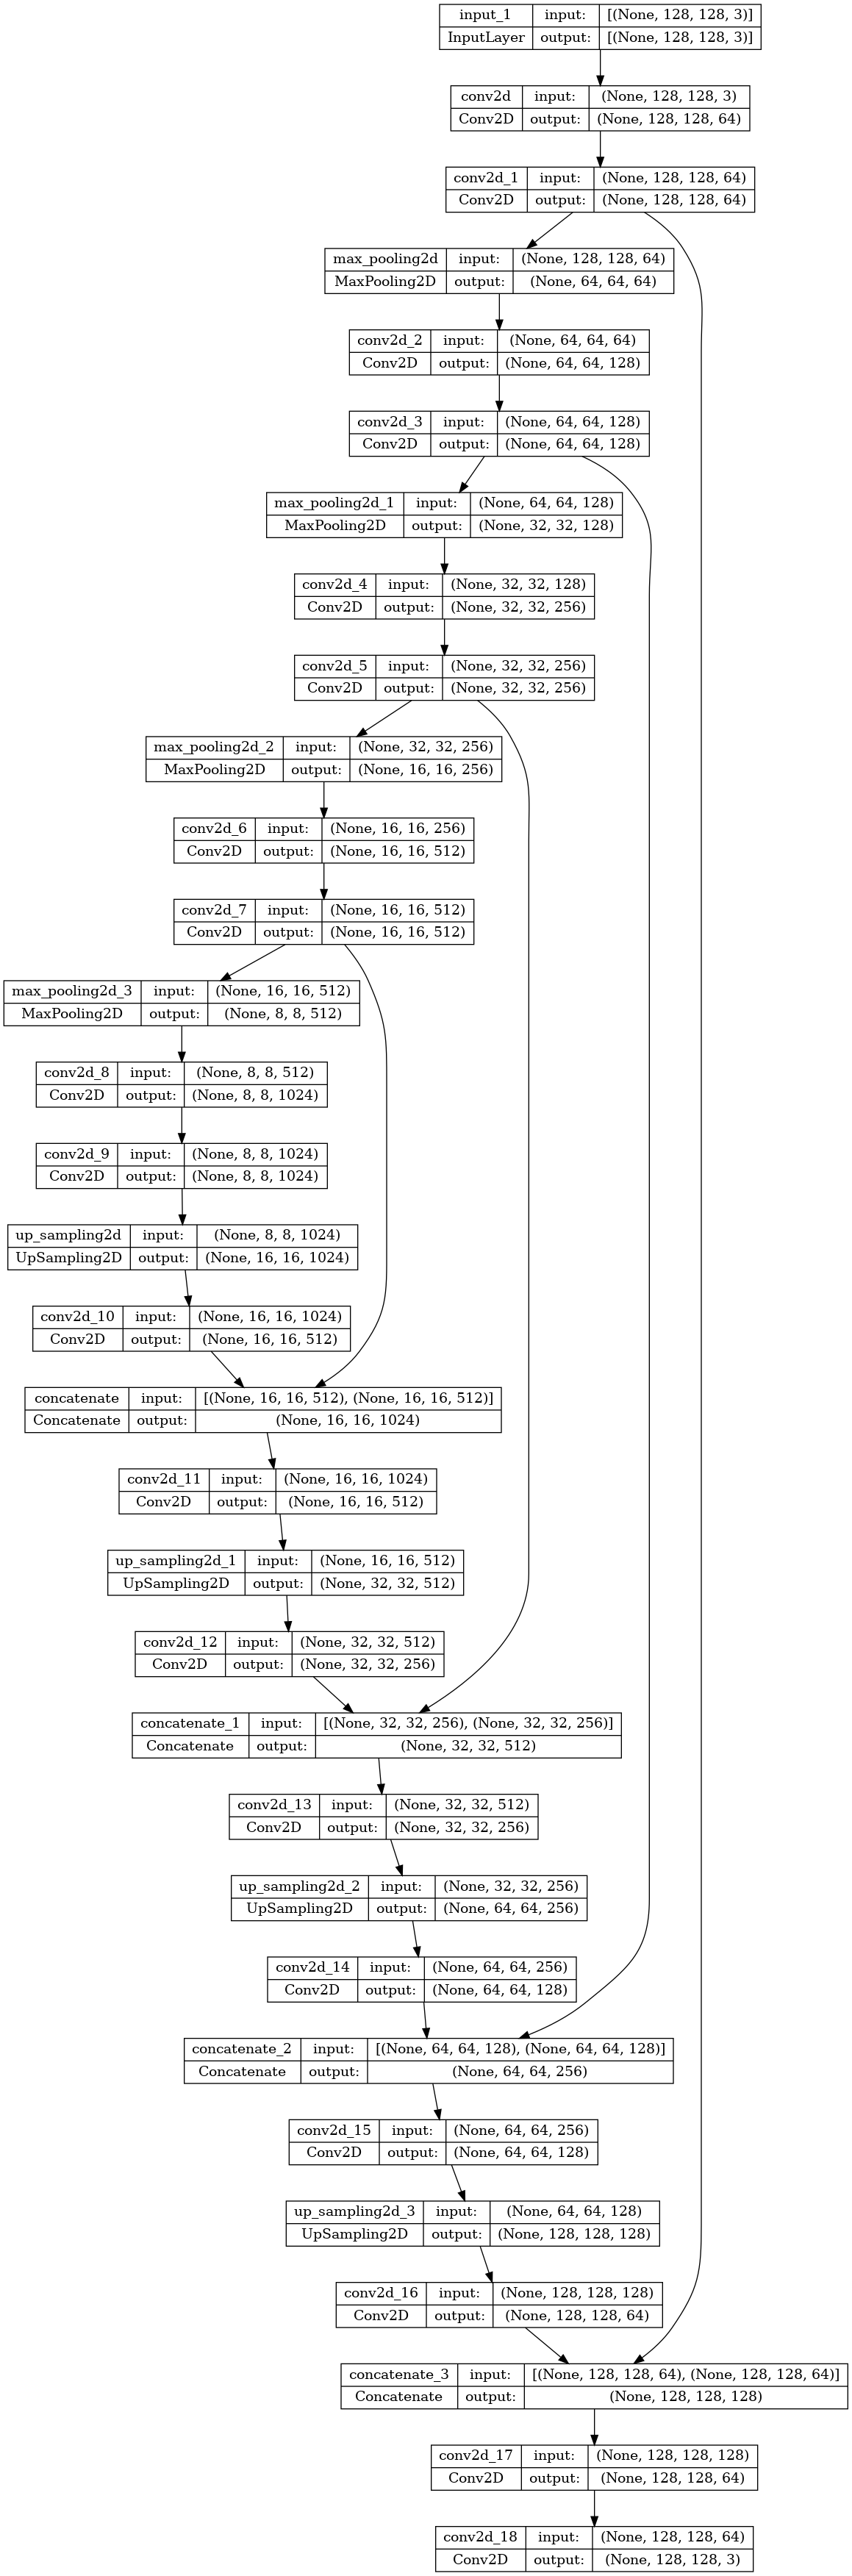

In [10]:
#%pip install pydot_ng==1.0.0 pydot graphviz
tf.keras.utils.plot_model(model, show_shapes=True)


In [153]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches)


Epoch 1/20
57/57 [==============================] - 16s 272ms/step - loss: 0.5274 - accuracy: 0.7918 - val_loss: 0.4938 - val_accuracy: 0.8031
Epoch 2/20
57/57 [==============================] - 15s 272ms/step - loss: 0.4960 - accuracy: 0.8048 - val_loss: 0.4589 - val_accuracy: 0.8210
Epoch 3/20
57/57 [==============================] - 15s 270ms/step - loss: 0.4488 - accuracy: 0.8246 - val_loss: 0.4458 - val_accuracy: 0.8260
Epoch 4/20
57/57 [==============================] - 15s 270ms/step - loss: 0.4184 - accuracy: 0.8366 - val_loss: 0.4241 - val_accuracy: 0.8333
Epoch 5/20
57/57 [==============================] - 15s 271ms/step - loss: 0.3988 - accuracy: 0.8447 - val_loss: 0.3926 - val_accuracy: 0.8489
Epoch 6/20
57/57 [==============================] - 15s 270ms/step - loss: 0.3735 - accuracy: 0.8553 - val_loss: 0.4048 - val_accuracy: 0.8434
Epoch 7/20
57/57 [==============================] - 15s 271ms/step - loss: 0.3616 - accuracy: 0.8600 - val_loss: 0.3804 - val_accuracy: 0.8529

In [158]:
model.evaluate(test_batches)

58/58 [==============================] - 6s 99ms/step - loss: 0.3235 - accuracy: 0.8826


[0.32348695397377014, 0.8825700879096985]

### Preview some of the model predictions

In [151]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask

(1, 128, 128, 3)
1/1 [==============================] - 0s 23ms/step


2024-02-26 17:13:36.392837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [4]
	 [[{{node Placeholder/_3}}]]
2024-02-26 17:13:36.393404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4]
	 [[{{node Placeholder/_0}}]]


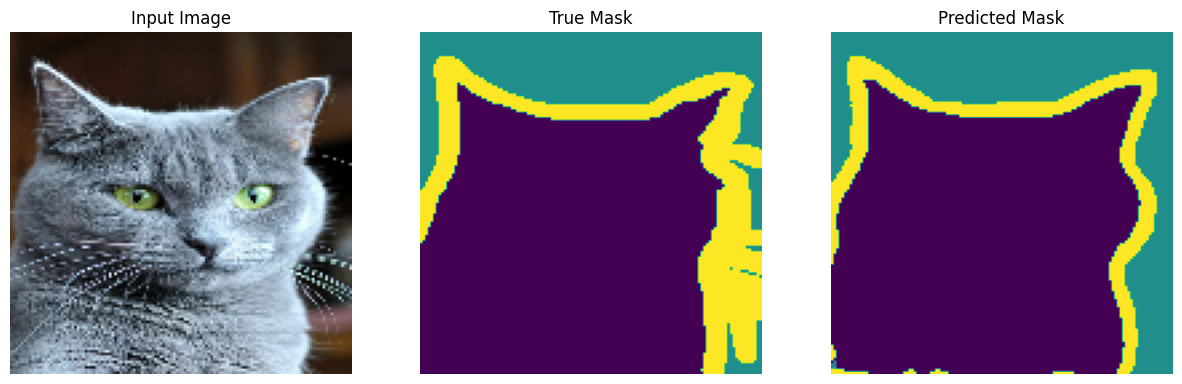

In [156]:
for images, masks in train_batches.take(1):
  sample_image, sample_mask = images[0], masks[0]

  image_exp = tf.expand_dims(sample_image, axis=0)
  print(image_exp.shape)
  pred_mask = model.predict(image_exp)[0]

  display([sample_image, sample_mask, create_mask(pred_mask)])